## SIMPLES MODELO DE CLASSIFICAÇÃO COM TENSORFLOW USANDO O DATASET IRIS

In [95]:
from IPython import display
import numpy as np # para computação numérica menos intensiva
import pandas as pd
from sklearn.datasets import load_iris
import os # para criar pastas
from matplotlib import pyplot as plt
import tensorflow as tf

# cria uma pasta para colocar os dados
if not os.path.exists('tmp'):
    os.makedirs('tmp')

In [2]:
iris = load_iris()

In [145]:
# SEPARA OS DADOS ENTRE TREINO E TESTE

In [168]:
TRAIN_FRACTION = 0.7

# junta os dados com label
data_train_test = e = np.column_stack((iris.data, iris.target))

# embaralha os dados
np.random.shuffle(data_train_test)

training_size = int(data_train_test.shape[0] * TRAIN_FRACTION)
training_data = data_train_test[0:training_size, :]
testing_data  = data_train_test[training_size:, :]

In [6]:
# HIPER-PARÂMETROS

In [148]:
lr = 0.01 # taxa de aprendizado
batch_size = 20 # tamanho do mini-lote
n_iter = 300 # total de iteraçẽos
n_inputs = 4 # qtd de dados de entrada
n_l1 = 512 # número de neurônios da primeira camada
n_l2 = 512 # número de neurônios da segunda camada
n_outputs = 3 # qtd de dados de saída

In [8]:
# CONSTRUÇÃO DO MODELO

In [149]:
def fully_connected_layer(inputs, n_neurons, name_scope, activation=None):
    
    '''Adiciona os nós de uma camadas ao grafo Tensorflow'''
    with tf.name_scope(name_scope):
    
        # variáveis da camada
        n_inputs = int(inputs.get_shape()[1])
        W = tf.Variable(tf.truncated_normal([n_inputs, n_neurons]), name='Weights')
        b = tf.Variable(tf.zeros([n_neurons]), name='biases')
        
        # operação linear
        layer = tf.add(tf.matmul(inputs, W), b)
        
        # aplica a não linearidade
        if activation == 'relu':
            layer = tf.nn.relu(layer, name='relu')
            
        return layer
    
graph = tf.Graph() # cria um grafo
with graph.as_default(): # abre o grafo para adicionar os nós
    
    # camadas de inputs
    with tf.name_scope('input_layer'):
        x_input = tf.placeholder(tf.float32, shape=[None, n_inputs], name='flores')
        y_input = tf.placeholder(tf.int64, shape=[None], name='labels')
        
    # camada 01
    l1 = fully_connected_layer(x_input, n_neurons=n_l1, name_scope='first_layer', activation='relu')
    
    # camada 02
    l2 = fully_connected_layer(l1, n_neurons=n_l2, name_scope='second_layer', activation='relu')
    
    # camada de saída
    logits = fully_connected_layer(l2, n_neurons=n_outputs, name_scope='output_layer')
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_input, logits=logits), name='error')

    # otimizador
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    
    outputs = tf.argmax(logits, 1)
    
    correct_prediction = tf.equal(outputs, y_input)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # inicializador
    init = tf.global_variables_initializer()
    
    # para salvar o modelo de treino
    saver = tf.train.Saver()

In [47]:
# EXECUÇÃO DO MODELO

In [150]:
def show_chart_accuracy(arr_acc, step):
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.plot(range(len(arr_acc)), arr_acc)
    plt.title('Accuracy')
    plt.ylabel('%')
    plt.xlabel('step %d' %(step/(n_iter/100)))
    plt.grid(True)
    
    plt.tight_layout()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.close()
    

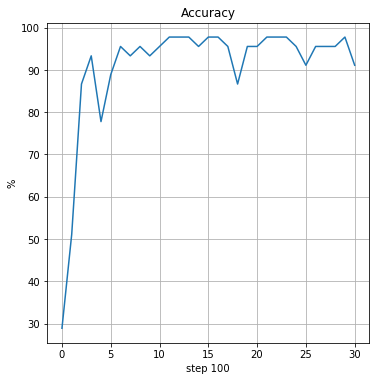

In [170]:
def accuracy1(predictions, labels):
    '''Compara dois vetores one-hot para produzir a acurácia'''
    
    pred_labels = np.argmax(predictions, 1)
    true_labels = np.argmax(labels, 1)
    
    return (pred_labels == true_labels).mean() * 100

# abre a sessão tf
with tf.Session(graph=graph) as sess:
    sess.run(init) # inicia as variáveis
    
    # cria o feed_dict de teste
    val_dict = {
        x_input: testing_data[:, 0:4], 
        y_input: testing_data[:, 4]
    }
    
    arr_acc = []

    for step in range(n_iter+1):
        batch = training_data[np.random.choice(training_size, batch_size, False), :]
        # cria o feed_dict de treino
        feed_dict = {
            x_input: batch[:, 0:4], 
            y_input: batch[:, 4]
        }
        
        # executa a interação de treino
        optimizer.run(feed_dict=feed_dict)
        
        # para mostrar o progresso a cada 10 iterações
        if step % 10 == 0:
            
            # calcula a acurácia
            acc = accuracy.eval(val_dict) * 100
            
            # adiciona no array o valor da acurácia de cada passo
            arr_acc.append(acc)
            
            # mostra o gráfico de acurácia
            show_chart_accuracy(arr_acc, step)
            
            # salva as variáveis do modelo
            saver.save(sess, './tmp/deep_ann.ckpt')                   

In [337]:
# PREDICT

In [171]:
# para classificar espécies com base nas medidas das sépalas e pétalas
with tf.Session(graph=graph) as sess:

    # restaura o valor das variáveis
    saver.restore(sess, './tmp/deep_ann.ckpt')
    
    # exemplo de medidas de uma espécie (comprimento e largura da sépala e pétala)
    pred_dict = [[0.1, 3.2, 0.2, 0.3]]

    # classifica a espécie
    output_data_classify = outputs.eval({x_input: pred_dict})
    
    species = iris.target_names[output_data_classify]
    
    print('Classificada como: %s' %(species))

INFO:tensorflow:Restoring parameters from ./tmp/deep_ann.ckpt
Classificada como: ['setosa']
